ใน ep ที่แล้วเราใช้ Naive Bayes และ [Logistic Regression](https://www.bualabs.com/archives/1945/what-is-cross-entropy-loss-logistic-regression-log-loss-loss-function-ep-3/) ที่เป็นอัลกอริทึมที่เป็นที่นิยมก่อนยุค Deep Learning แต่ใน ep นี้เราจะเปลี่ยนมาใช้ Deep Neural Network และ Transfer Learning เรียกว่า [ULMFit](https://www.bualabs.com/archives/tag/ulmfit/) หรือ Universal Language Model Fine-tuning ที่จะลดเวลาการเทรน และเพิ่มประสิทธิภาพการทำงานของโมเดล AWD_LSTM ซึ่งเป็น LSTM / Recurrent Neural Network (RNN) แบบนึง ที่มีการใช้ [Dropout](https://www.bualabs.com/archives/1533/what-is-dropout-benefits-dropout-reduce-overfit-deep-learning-training-model-deep-neural-network-regularization-ep-2/) หลากหลายแบบภายในส่วนต่าง ๆ ของโมเดล

# 0. Install

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Install Library ที่จำเป็น

In [2]:
## Colab
! curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


เช็ค GPU

In [3]:
! nvidia-smi

Tue Dec 10 16:39:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Import

Import Library ที่จะใช้ ในที่นี้คือ fastai และ fastai.text 

In [0]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.callbacks.mem import *

In [0]:
# import fastai.utils.collect_env
# fastai.utils.collect_env.show_install()

สำหรับ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) เราจะกำหนด path ที่เก็บ DataSet และ Mount Google Drive 

In [6]:
dataset = 'imdb_sample'
dataset2 = 'imdb'

# Google Colab
config_path = Path('/content/drive')
data_path_base = Path('/content/datasets/')

data_path = data_path_base/dataset
data_path2 = data_path_base/dataset2

from google.colab import drive
drive.mount(str(config_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Dataset

ในเคสนี้เราจะใช้ IMDB Movie Review เป็นรีวิวหนังจากเว็บ IMDB ที่มีข้อความ และ คะแนนว่าเป็นแง่บวก หรือแง่ลบ เหมือนใน ep ก่อน ๆ 

ในการพัฒนา เราจะใช้ Dataset ชุดเล็กก่อน จะได้เร็ว เมื่อเทสทุกอย่างเรียบร้อย แล้วจึงขยับไปใช้ Dataset ชุดเต็ม 

In [7]:
path = untar_data(URLs.IMDB_SAMPLE, dest=data_path)
path.ls()

[PosixPath('/content/datasets/imdb_sample/imdb_sample/texts.csv')]

# 3. Preprocessing

## 3.1 Data Block API

เราจะใช้ [Data Block API](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) กำหนด Data Pipeline ทีละขั้น Tokenization, Numericalization, Split, Labeling ก็จะทำให้ยืดหยุ่นมากขึ้น

In [8]:
data_lm = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

ดูตัวอย่างคำศัพท์ใน vocab Dictionary

In [9]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

ดูตัวอย่างข้อมูล text

In [10]:
data_lm.train_ds[0][0]

Text xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !

ดูข้อมูลภายใน ในรูปแบบตัวเลข

In [11]:
data_lm.train_ds[0][0].data[:20]

array([   2,    5, 4619,   25,    0,   25,  867,   52,    5, 3776,    5, 1800,   95,   37,   85,  191,   64,  935,
          0, 2738])

# 2/2. Full Dataset

Download ชุดข้อมูลตัวเต็ม IMDB DataSet ไปไว้ใน path ที่กำหนด

In [12]:
path = untar_data(URLs.IMDB, dest=data_path2)
path.ls()

[PosixPath('/content/datasets/imdb/imdb/lm_databunch'),
 PosixPath('/content/datasets/imdb/imdb/README'),
 PosixPath('/content/datasets/imdb/imdb/imdb.vocab'),
 PosixPath('/content/datasets/imdb/imdb/train'),
 PosixPath('/content/datasets/imdb/imdb/test'),
 PosixPath('/content/datasets/imdb/imdb/tmp_lm'),
 PosixPath('/content/datasets/imdb/imdb/tmp_clas'),
 PosixPath('/content/datasets/imdb/imdb/unsup')]

In [13]:
(path/'train').ls()

[PosixPath('/content/datasets/imdb/imdb/train/pos'),
 PosixPath('/content/datasets/imdb/imdb/train/labeledBow.feat'),
 PosixPath('/content/datasets/imdb/imdb/train/neg'),
 PosixPath('/content/datasets/imdb/imdb/train/unsupBow.feat')]

# 3/2. Preprocessing

[Data Pipeline](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) ด้วย Data Block API

In [0]:
# bs=48
# bs=24
bs=64

In [15]:
data_lm = (TextList.from_folder(path)
                    .filter_by_folder(include=['train', 'test', 'unsup'])
                    .split_by_rand_pct(0.1)
                    .label_for_lm()
                    .databunch(bs=bs, num_workers=1))

ในข้อมูล Training Set 90,000 Record มีคำศัพท์ 60,000 คำ (Default)

In [16]:
len(data_lm.vocab.itos), len(data_lm.train_ds)

(60000, 90000)

In [17]:
data_lm.show_batch()

idx,text
0,"powell - say no more . xxmaj the plot is intricate . xxmaj the story moves all too quickly , because you want it to last . xxmaj enjoy . xxbos xxmaj well , what can i say , this movie really got to me , it 's not so bad , as many say , i really loved it , although the idea seems so simple , and rather"
1,"like xxmaj will xxmaj ferrell but here he just never clicked for me . xxmaj and the rest of the guys were just xxunk who tagged along , and in the end all decided that having their wives / girlfriends cheat on them was in fact their fault . xxmaj so back to the main story . xxmaj the story basically centers around xxmaj leon and sex . xxmaj so"
2,"of killing her , he really kills only her spirit and will to live , after which she becomes a drug addict and ultimately dies from an overdose . xxmaj the story is n't about the street life or the xxmaj italian mobster who tries to buy xxmaj stix off , then threatens him , it 's about how love can overcome even the worst tragedies in life as portrayed"
3,"beginning . xxmaj they graduated together , they go to parties together and they decide to go to xxmaj bangkok together when they were supposed to be going to xxmaj hawaii . xxmaj they also get busted for attempting to smuggle drugs into a third world country and that spells disaster . xxmaj the rest of the film is about survival and not giving up hope . xxmaj it also"
4,"his offering of the xxunk willed brother xxmaj kyle xxmaj hadley , a mere shadow of his patriarchal father . xxmaj when he finds out that he is unable to impregnate his new bride ( a beautifully xxunk xxmaj lauren xxmaj bacall ) , xxmaj hadley goes off the deep end , escalating an already serious drinking problem with a "" secret "" gun fetish that threatens to make him"


เซฟไว้ก่อน คราวหน้าจะได้ไม่ต้องเสียเวลา Preprocess ใหม่

In [0]:
data_lm.save('lm_databunch')

โหลด Language Model DataBunch ที่เซฟไว้ แล้วเช็คข้อมูล

In [19]:
data_lm = load_data(path, 'lm_databunch', bs=bs)
len(data_lm.vocab.itos), len(data_lm.train_ds)

(60000, 90000)

# 4. Language Model จาก WikiText-103

## 4.1 AWD_LSTM Model Architecture

สร้าง Language Model Learner ขึ้นมา โดยใช้ data_lm จาก IMDB ด้านบน และ สถาปัตยกรรม AWD_LSTM [Model Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) โดยที่ยังไม่ได้เริ่มต้นเทรน

AWD_LSTM ได้ถูก Pre-Train กับ WikiText-103 Dataset เรียบร้อยแล้ว

In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, 
                                  drop_mult=0.3, model_dir=config_path/'My Drive/models', 
                                  callback_fns=[ShowGraph, PeakMemMetric])
# learn_lm

In [21]:
learn_lm.model[0]

AWD_LSTM(
  (encoder): Embedding(60000, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(60000, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

In [22]:
learn_lm.model[0].encoder

Embedding(60000, 400, padding_idx=1)

## 4.2 vocab Dictionary ของ WikiText-103 

โหลด Dictionary ของ WikiText-103 ขึ้นมา 

Language Model ต้องมาพร้อมกับ vocab Dictionary เสมอ ไม่เช่นนั้นเราจะไม่รู้ว่า คำศัพท์ไหนเป็นคำไหน เพราะในโมเดลจะมีแต่ตัวเลข Index / Embedding

In [23]:
Config().model_path().ls()

[PosixPath('/root/.fastai/models/wt103-fwd.tgz'),
 PosixPath('/root/.fastai/models/wt103-fwd')]

In [24]:
(Config().model_path()/'wt103-fwd').ls()

[PosixPath('/root/.fastai/models/wt103-fwd/lstm_fwd.pth'),
 PosixPath('/root/.fastai/models/wt103-fwd/itos_wt103.pkl')]

In [0]:
wiki_itos = pickle.load(open(Config().model_path()/'wt103-fwd/itos_wt103.pkl', 'rb'))

ดูจำนวนคำศัพท์ ตัวอย่างข้อมูล หัว / ท้าย

In [26]:
len(wiki_itos), wiki_itos[:20], wiki_itos[-20:]

(60000,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'the',
  ',',
  '.',
  'of',
  'and',
  'in',
  'to',
  'a',
  '=',
  '"',
  'was'],
 ['repaying',
  'ak-47',
  'cultic',
  'jaume',
  'leonis',
  'subtracting',
  'sexed',
  'bursa',
  '-style',
  'lithographs',
  'wgbh',
  'subsystem',
  '831',
  'lifelines',
  'bergeron',
  'adaptions',
  'slurs',
  'acasta',
  'stuccoed',
  'spellbound'])

## 4.3 vocab Dictionary ของ IMDB

ดูตัวอย่างคำศัพท์ใน IMDB

In [0]:
vocab = data_lm.vocab

In [0]:
imdb_itos = vocab.itos

In [29]:
vocab.stoi['love']

135

In [30]:
imdb_itos[vocab.stoi['love']]

'love'

In [31]:
imdb_itos[vocab.stoi['Sukhumvit']]

'xxunk'

In [0]:
awd = learn_lm.model[0]

In [0]:
# from scipy.spatial.distance import cosine as dist

In [0]:
enc = learn_lm.model[0].encoder

Embedding 400 มิติของ คำศัพท์ 60,000 คำ

In [35]:
enc.weight.size()

torch.Size([60000, 400])

## 4.4 Difference in vocab between IMDB and Wikipedia

เปรียบเทียบ 2 vocab Dictionary พบว่า ขนาด vocab เท่ากัน

In [36]:
len(wiki_itos), len(imdb_itos)

(60000, 60000)

แต่ข้างใน ไม่เหมือนกัน เปรียบเทียบ 10 คำศัพท์สุดท้าย

In [37]:
wiki_itos[-10:], imdb_itos[-10:]

(['wgbh',
  'subsystem',
  '831',
  'lifelines',
  'bergeron',
  'adaptions',
  'slurs',
  'acasta',
  'stuccoed',
  'spellbound'],
 ['officialdom',
  'r.c.',
  'it´d',
  'scrye',
  'montegna',
  'diffuses',
  '30-odd',
  'usurious',
  'sassoon',
  'gojo'])

In [0]:
wiki_words = set(wiki_itos)
imdb_words = set(imdb_itos)

คำศัพท์ที่อยู่ใน vocab ของ Wiki แต่ไม่อยู่ใน vocab ของ IMDB

In [39]:
wiki_not_imdb = wiki_words.difference(imdb_words)
len(wiki_not_imdb), [val for i, val in enumerate(itertools.islice(wiki_not_imdb, 20))]

(24252,
 ['riverton',
  'gálvez',
  'sof',
  'elmham',
  'parkour',
  'garten',
  '659',
  'reinterpretation',
  'catharines',
  'minardi',
  'carlota',
  '48-yard',
  'laidlaw',
  'pyrite',
  'comix',
  '3,900',
  'stockport',
  'foxe',
  'thulium',
  '1809'])

คำศัพท์ที่อยู่ใน vocab ของ IMDB แต่ไม่อยู่ใน vocab ของ Wiki

In [40]:
imdb_not_wiki = imdb_words.difference(wiki_words)
len(imdb_not_wiki), [val for i, val in enumerate(itertools.islice(imdb_not_wiki, 20))]

(24252,
 ['pederast',
  'scams',
  'appeasing',
  'prowler',
  'sultanpuri',
  'atavistic',
  'skateboards',
  'modernistic',
  'doogie',
  'magnify',
  'imbecility',
  'hakufu',
  '\x85 \n \n ',
  'soper',
  'kushrenada',
  'broeck',
  'snarf',
  'junge',
  'ripoffs',
  'dillman'])

## 4.5 Out of vocab Initialization

คำว่า verification อยู่ใน vocab ของ WikiText-103 แต่ไม่อยู่ใน IMDB

In [41]:
w = "verification"
vocab.stoi[w], w in wiki_words, w in imdb_words

(0, True, False)

คำเหล่านี้ อยู่ใน vocab ของ IMDB แต่ไม่อยู่ใน WikiText-103 เราจะ Initialize Embedding ของคำเหล่านี้ แบบ Random

In [42]:
w = "senselessness"
vocab.stoi[w], w in wiki_words, w in imdb_words

(38962, False, True)

In [43]:
w = "unthinking"
vocab.stoi[w], w in wiki_words, w in imdb_words

(26417, False, True)

In [44]:
w = "forklift"
vocab.stoi[w], w in wiki_words, w in imdb_words

(46579, False, True)

Initialize ด้วยค่า Random เล็ก ๆ ใกล้เคียงกัน

In [45]:
np.allclose(enc.weight[vocab.stoi['senselessness'], :], 
            enc.weight[vocab.stoi['unthinking'], :])

True

แต่ถ้าเทียบกับ Embedding ที่เทรนเรียบร้อยแล้ว ก็จะต่างกันมาก

In [46]:
np.allclose(enc.weight[vocab.stoi['senselessness'], :], 
            enc.weight[vocab.stoi['capital'], :])

False

3 คำแรกมีใน IMDB แต่คำสุดท้ายไม่มี

In [47]:
vocab.stoi['senselessness'], vocab.stoi['unthinking'], vocab.stoi['capital'], vocab.stoi['cpu']

(38962, 26417, 5919, 0)

ดู Embedding ของคำที่มีใน IMDB แต่ไม่มีใน Wiki จะเห็นว่าเท่ากันมีค่าเท่ากัน

In [48]:
len(enc.weight[vocab.stoi['senselessness'], :]), enc.weight[vocab.stoi['senselessness'], :][:50]

(400,
 tensor([ 0.0253,  0.0026,  0.0423, -0.0274, -0.0110, -0.0100, -0.0628,  0.1794,
         -0.1275, -0.2096, -0.0124, -0.0056, -0.0505, -0.0501, -0.0428,  0.1726,
         -0.0650, -0.0571, -0.1103,  0.0186,  0.0053, -0.0059,  0.0299,  0.0192,
         -0.0240,  0.1432, -0.1064, -0.0097,  0.0100, -0.0399,  0.0282,  0.0319,
          0.1297,  0.0687, -0.0047,  0.0168,  0.0201,  0.1346, -0.0336, -0.0449,
          0.0265, -0.0756, -0.0225,  0.0196,  0.0221,  0.0214,  0.0077, -0.1311,
         -0.1357, -0.0128], device='cuda:0', grad_fn=<SliceBackward>))

In [49]:
len(enc.weight[vocab.stoi['unthinking'], :]), enc.weight[vocab.stoi['unthinking'], :][:50]

(400,
 tensor([ 0.0253,  0.0026,  0.0423, -0.0274, -0.0110, -0.0100, -0.0628,  0.1794,
         -0.1275, -0.2096, -0.0124, -0.0056, -0.0505, -0.0501, -0.0428,  0.1726,
         -0.0650, -0.0571, -0.1103,  0.0186,  0.0053, -0.0059,  0.0299,  0.0192,
         -0.0240,  0.1432, -0.1064, -0.0097,  0.0100, -0.0399,  0.0282,  0.0319,
          0.1297,  0.0687, -0.0047,  0.0168,  0.0201,  0.1346, -0.0336, -0.0449,
          0.0265, -0.0756, -0.0225,  0.0196,  0.0221,  0.0214,  0.0077, -0.1311,
         -0.1357, -0.0128], device='cuda:0', grad_fn=<SliceBackward>))

ต่างกับค่าที่มีใน Wiki

In [50]:
len(enc.weight[vocab.stoi['capital'], :]), enc.weight[vocab.stoi['capital'], :][:50]

(400,
 tensor([-0.2566,  0.1062,  0.3081,  0.2742,  0.1667, -0.1626, -0.5122, -0.1261,
          0.4548, -0.4177, -0.1565,  0.0752,  0.2253,  0.2031, -0.3125,  0.0310,
          0.5112, -0.3691, -0.2947, -0.0168, -0.1147,  0.3074, -0.1654, -0.2202,
          0.0538, -0.4041,  0.1666, -0.0109, -0.2803,  0.3044, -0.2279,  0.1786,
         -0.2502, -0.2334,  0.4438,  0.2404,  0.1746,  0.1509,  0.0351,  0.2844,
         -0.0244, -0.2031,  0.1228, -0.2357, -0.2065,  0.5811,  0.1338,  0.4087,
         -0.5034, -0.0150], device='cuda:0', grad_fn=<SliceBackward>))

## 4.6 Fake Movie Reviews from WikiText Language Model

เราจะลองใช้ Language Model ที่ Pre-Train จาก Wikipedia มาลองสร้าง รีวิวหนัง Movie Reviews ดูว่าจะเป็นอย่างไร

ชอบหนังเรื่องนี้เพราะว่า

In [0]:
TEXT = "I loved this film because"
N_WORDS = 60
N_SENTENCES = 3

In [52]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I loved this film because of its allusions to the theme of hopkins . In the films , Jenny Collins uses it to enhance her imagination in the movie . In the film , Brittany is shown as a teenage girl in a small town , but when Brittany goes to school , she 's able to get away
I loved this film because of its similarities to the original film . The film is considered a lesson in terms of drama and cinematography in contrast to the style of many other productions . The opening scene also shows a scene of Elizabeth and Lindsay delivering Peter 's mother to the television . It was originally written when
I loved this film because i was a fan of the Star Wars films . So i felt that after the film aired , i had the idea of making a movie . But that was very natural to me . It was a great film and i was very happy with it . i wanted to write a film


ไม่ชอบหนังเรื่องนี้เพราะว่า

In [0]:
TEXT = "I hated this movie because"
N_WORDS = 60
N_SENTENCES = 3

In [54]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie because of its resemblance to the two Stephen King films that were raj by other actors . In 1997 , Clues Online magazine listed Snowball II 's Slash as the ones that had the most explicit character name . In order to expressed interest in Defended Bush , the character
I hated this movie because " it doesn ' t matter how quickly the movie begins to realize that it 's going to be a movie . There are no other boys who do it . " The film is also the first American film to use a third - person perspective . The British film industry was skeptical of
I hated this movie because of its creative style . In the 1990s , the films were a part of a long - running film that incorporated the " dark " themes from American horror films , including the Discovery Channel series The Evil Dead , and the film The Lion King . On


หนังเรื่องนี้ ... จริง ๆ

In [0]:
TEXT = "This movie is really"
N_WORDS = 60
N_SENTENCES = 3

In [56]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie is really based on the novel The Hills of Truth by British author Philip Lawrence , based on the song " The Boat " . The episode features a new character , Bill Henry , based on a real - life U.S. Army general who would have been painted
This movie is really about the United States and Germany . It is the first UK drama about The Red Hot Chili Peppers , which is the first in a series of worldwide films . The film was made with the exception of The Best of John Lennon ,
This movie is really the first in a series of films , which do not feature a narrative in the first person . The first two cents are based on the same theory of Gilbert Scott . The third is the James Bond film , The Devil 's Dyke Schoolteachers , and also the


จะเห็นว่า รีวิวหนังที่ได้ ค่อนข้างจะมีความเป็น Wikpedia อยู่มาก สำนวน คำศัพท์ต่าง ๆ ไม่ค่อยเหมือนรีวิวหนังทั่วไป

ลองลด temperature ลง ทำให้ข้อความ Random น้อยลง รีวิวหนังที่ได้จะคล้าย ๆ กันมากขึ้น

In [0]:
TEXT = "This movie is really"
N_WORDS = 60
N_SENTENCES = 3

In [58]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.1) for _ in range(N_SENTENCES)))

This movie is really a British film , and it is a film that is not a direct sequel to The Lord of the Rings . The film was released on DVD in November 2009 , and in Europe on March 25 , 2010 . The film was released on DVD in
This movie is really a Hollywood film , and it is a film that is not a direct sequel to The Legend of Zelda : The Legend of Zelda : The Adventure of Time . The film was released on November 8 , 2005 , and was released on November 19
This movie is really a British film , and it is a British film . The film was released in North America on November 1 , 2007 , and in Australia on March 19 , 2008 . The film was released in North America on March 15 , 2008 , and in


# 5. Train Model

## 5.1 Train Last Layer

เทรน Layer สุดท้าย

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 5.75E-03


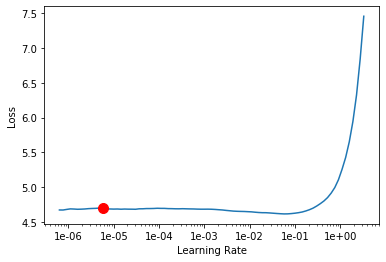

In [59]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion=True)

In [0]:
lr = 1e-2

In [0]:
learn_lm.to_fp16();

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,4.123864,4.100370,0.300000,1,1,-200,4104,20:21


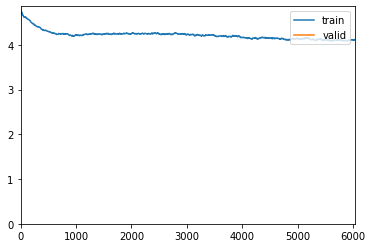

In [62]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8, 0.7), 
                       callbacks=[SaveModelCallback(learn_lm, every='epoch', monitor='accuracy')])

In [0]:
learn_lm.save("26g-01")

In [0]:
learn_lm.load("26g-01");

## 5.2 Unfreeze and Train whole model

In [0]:
learn_lm.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


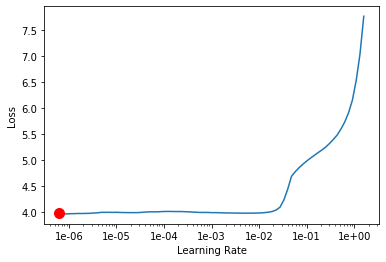

In [65]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion=True)

In [0]:
lr = slice(3e-6, 3e-3)

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,3.939306,3.985536,0.300000,0,0,-2,4618,23:17
1,3.921177,4.018639,0.314286,1,1,0,4620,23:18
2,3.870077,3.962120,0.300000,1,1,0,4620,23:17
3,3.821481,3.835240,0.285714,1,1,0,4620,23:22
4,3.800610,3.801917,0.285714,1,1,0,4620,23:18
5,3.744155,3.772275,0.300000,1,1,0,4620,23:28
6,3.714456,3.744945,0.314286,1,1,0,4620,23:22
7,3.699814,3.759515,0.285714,1,1,0,4620,23:20
8,3.654778,3.742450,0.285714,2,2,0,4620,23:18
9,3.625699,3.746034,0.285714,2,2,0,4620,23:19


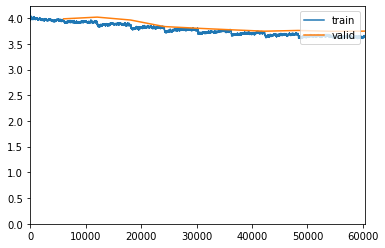

In [67]:
learn_lm.fit_one_cycle(10, max_lr=lr, moms=(0.8, 0.7), 
                      callbacks=[SaveModelCallback(learn_lm, every='epoch', monitor='accuracy')])

In [0]:
learn_lm.save("26g-02")

In [0]:
learn_lm.save_encoder("26g-02-enc")

In [0]:
learn_lm.load("26g-02");

## 5.3 Check Embedding Again

ลองเช็คอีกครั้ง หลังจากเทรนเสร็จแล้ว Embedding ของทั้ง 2 คำ มีค่าต่างกันแล้ว

In [70]:
np.allclose(enc.weight[vocab.stoi['senselessness'], :], 
            enc.weight[vocab.stoi['unthinking'], :])

False

3 คำแรกมีใน IMDB แต่คำสุดท้ายไม่มี

In [71]:
vocab.stoi['senselessness'], vocab.stoi['unthinking'], vocab.stoi['capital'], vocab.stoi['cpu']

(38962, 26417, 5919, 0)

ดู Embedding ของคำที่มีใน IMDB แต่ไม่มีใน Wiki จะเห็นว่าแต่ละคำค่า Embedding ได้เปลี่ยนไปเรียบร้อยแล้ว ไม่มีคำไหนค่าซ้ำกันเลย

In [72]:
len(enc.weight[vocab.stoi['senselessness'], :]), enc.weight[vocab.stoi['senselessness'], :][:50]

(400,
 tensor([-0.2023, -0.1573, -0.0277,  0.2522, -0.0203,  0.1085,  0.3975,  0.0161,
          0.1216, -0.0328, -0.1149,  0.0305, -0.0370,  0.0123,  0.0242, -0.0953,
         -0.2336,  0.0966,  0.0336,  0.0677,  0.1840,  0.0847, -0.0068,  0.0691,
         -0.1005, -0.2451,  0.1277, -0.1403,  0.0051,  0.1948, -0.0078, -0.0743,
         -0.1111,  0.0400,  0.0383,  0.1671,  0.0954, -0.2947,  0.0581,  0.0281,
          0.3806,  0.0381, -0.2537,  0.0029,  0.0184,  0.0618,  0.0869, -0.1290,
          0.0025,  0.1906], device='cuda:0', dtype=torch.float16,
        grad_fn=<SliceBackward>))

In [73]:
len(enc.weight[vocab.stoi['unthinking'], :]), enc.weight[vocab.stoi['unthinking'], :][:50]

(400,
 tensor([-0.1027,  0.1511, -0.1090,  0.0330, -0.0117,  0.0690,  0.2969, -0.0157,
          0.2308,  0.0966, -0.0875, -0.4749,  0.0226, -0.1428, -0.1274,  0.1375,
         -0.0386, -0.2820,  0.0095,  0.0525,  0.2212,  0.0768,  0.2157,  0.4131,
         -0.0939, -0.4763,  0.0080, -0.1792, -0.0387, -0.0099,  0.0052, -0.0321,
         -0.0403, -0.0871, -0.1194,  0.1384,  0.1794, -0.2827, -0.1138,  0.2373,
          0.1898, -0.0667,  0.0382,  0.2771,  0.2269,  0.3965, -0.0714, -0.0354,
          0.1058, -0.3015], device='cuda:0', dtype=torch.float16,
        grad_fn=<SliceBackward>))

In [74]:
len(enc.weight[vocab.stoi['capital'], :]), enc.weight[vocab.stoi['capital'], :][:50]

(400,
 tensor([-0.1807,  0.1582,  0.5195,  0.1816,  0.3691, -0.0329, -0.2534, -0.1193,
          0.6143,  0.1500, -0.5503,  0.1927, -0.0535,  0.2852, -0.0188,  0.0476,
          0.2917, -0.0358,  0.0135, -0.1321,  0.5972,  0.1395, -0.0804,  0.4829,
          0.2629, -0.1587,  0.8032, -0.2430,  0.1819,  0.4084, -0.1952,  0.0948,
         -0.1327, -0.3279,  0.0662,  0.5527,  0.3108, -0.7056,  0.0390,  0.2671,
          0.1377, -0.7456, -0.3389, -0.1962,  0.2673,  0.6538,  0.4553,  0.3777,
         -0.0450, -0.1816], device='cuda:0', dtype=torch.float16,
        grad_fn=<SliceBackward>))

## 5.4 Fake Movie Reviews from IMDB Language Model

เราจะลอง Generate รีวิวหนัง Movie Reviews ใหม่จาก Language Model ที่เราเพิ่งเทรนกับ IMDB DataSet เสร็จ

ชอบหนังเรื่องนี้เพราะว่า

In [0]:
TEXT = "I loved this film because"
N_WORDS = 60
N_SENTENCES = 3

In [76]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I loved this film because of how much more screen time it had . This film is very watchable . i do believe that it is the same set , but it is a very good film . It is also enjoyable , especially to the point . The men in this movie are excellent but it is not too real to
I loved this film because it was a nice little film and i was very disappointed . The story was good , but i did n't think that it was funny and could n't be more entertaining . It 's a shame the people who made films such as Bank Of The Boat have already seen it and i
I loved this film because of the comments i saw on the whole but overall it was a true classic . It 's beautifully shot and the music is great . It is the best film i 've ever seen . It is almost the only film i have ever seen that i have seen , nearly all of my memory .


ไม่ชอบหนังเรื่องนี้เพราะว่า

In [0]:
TEXT = "I hated this movie because"
N_WORDS = 60
N_SENTENCES = 3

In [78]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie because of the characters . For example , Fred Gwynne did a good thing . He did the bad work . He was the worst character in the movie . Many of the actors were bad . In fact , the movie had got worse . 
 
  The acting is bottom - class
I hated this movie because the plot was terribly weak . Sitting in a toilet at the end i felt i had wasted my time . The movie was n't funny at all ! It 's not even that funny . The movie is not scary in a funny way . The music is stupid and the music is n't
I hated this movie because it 's so bad it 's funny . Even Jason Lee is hilarious . The movie is just a joke , it 's just really bad . i do n't think anyone on the IMDB list would like this movie . It 's bad worst movie that you have to watch because of the


หนังเรื่องนี้ ... จริง ๆ

In [0]:
TEXT = "This movie is really"
N_WORDS = 60
N_SENTENCES = 3

In [80]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie is really cool and it really kicks off . The story , the cinematography , the very idea of shooting a man and the woman in a bank full of attractive women . It was very good . It 's very entertaining . i think it was a lot better than it should be . i love the "
This movie is really really great . i have seen it many times , and i remember how it ended . It has a strong story and a good story , and is very brilliant and very touching . The cinematography is wonderful and the use of the actors is awesome . i 've never seen another movie with a great story
This movie is really just a boring excuse for a movie at the beginning . As with the movie , it is a little weak . The direction by Fred Olen Ray is awful to say the least . This movie is a disappointment . The acting is sub par , and the story is muddled .


จะได้รีวิวหนัง Movie Reviews ที่เหมือนรีวิวหนังมากขึ้น

ลด temperature ลง ทำให้ข้อความ Random น้อยลง

In [0]:
TEXT = "This movie is really"
N_WORDS = 60
N_SENTENCES = 3

In [82]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.1) for _ in range(N_SENTENCES)))

This movie is really bad . It 's not even funny . It 's not funny . It 's not funny . It 's not funny . It 's not funny . It 's not funny . It 's just a comedy . It 's not funny . It 's not funny . It
This movie is really bad . It 's not even funny . It 's not funny , it 's just a bunch of stupid jokes . The jokes are so stupid that it 's funny . The jokes are so stupid that i ca n't even think of them . The jokes are so stupid that i ca n't
This movie is really bad . It 's not even funny . The plot is predictable , the acting is bad , the plot is stupid , the acting is bad , and the plot is so bad that it 's funny . The acting is terrible , the plot is ridiculous , the plot is ridiculous , and the acting


# 6. Classifier

กลับมาที่งานหลักของเรา ในเคสนี้ คือ การ [Sentiment Analysis](https://www.bualabs.com/archives/tag/sentiment-analysis/) หรือ Sentiment Classification ว่ารีวิวหนัง Movie Review จะอยู่ใน Class ไหน ใน 2 Class ว่าเป็นรีวิวแง่บวก หรือแง่ลบ Positive หรือ Negative

## 6.1 สร้าง Databunch ใหม่สำหรับ Classifier

ใช้ Data Block API สร้าง Data Pipeline ใหม่ สำหรรับงาน Classifier ที่จะมี label เป็น positive, negative

In [0]:
bs = 48

In [84]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
            .split_by_folder(valid='test')
            .label_from_folder(classes=['neg', 'pos'])
            .databunch(bs=bs, num_workers=8))

In [0]:
data_clas.save('26g_imdb_textlist_clas')

In [0]:
data_clas = load_data(path, '26g_imdb_textlist_clas', bs=bs, num_workers=8)

In [87]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj chris xxmaj rock deserves better than he gives himself in "" xxmaj down xxmaj to xxmaj earth . "" xxmaj as directed by brothers xxmaj chris & xxmaj paul xxmaj weitz of "" xxmaj american xxmaj pie "" fame , this uninspired remake of xxmaj warren xxmaj beatty 's 1978 fantasy "" xxmaj heaven xxmaj can xxmaj wait , "" itself a rehash of 1941 's "" xxmaj",neg
"xxbos xxunk ) is the developing world 's answer to xxmaj silence of the xxmaj lambs . xxmaj where ` xxmaj silence ' terrorized our peace of mind , ` xxmaj citizen ' exhausts and saddens us instead . xxmaj this dramatization of the xxmaj chikatilo case translates rather well , thanks to a xxmaj westernized friendship between two xxmaj rostov cops who become equals . \n \n citizenx",pos
"xxbos xxmaj by 1987 xxmaj hong xxmaj kong had given the world such films as xxmaj sammo xxmaj hung 's ` xxmaj encounters of the xxmaj spooky xxmaj kind ' xxmaj chow xxmaj yun xxmaj fat in xxmaj john xxmaj woo 's iconic ` a xxmaj better xxmaj tomorrow ' , ` xxmaj zu xxmaj warriors ' and the classic ` xxmaj mr xxmaj vampire ' . xxmaj jackie xxmaj",pos
"xxbos xxmaj how strange the human mind is ; this center of activity wherein perceptions of reality are formed and stored , and in which one 's view of the world hinges on the finely tuned functioning of the brain , this most delicate and intricate processor of all things sensory . xxmaj and how much do we really know of it 's inner - workings , of it 's",pos


## 6.2 สร้าง Learner สำหรับงาน Classifier

สร้าง learner สำหรับงาน Classifier แล้ว Load Encoder จาก Language Model ที่เทรนจาก Wiki-103 และ Fine-Tune ด้วย IMDB Dataset ด้านบน เป็นการ Transfer Learning เรียกว่า ULMFit

In [0]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, 
                                     drop_mult=0.3, model_dir=config_path/'My Drive/models', 
                                     callback_fns=[ShowGraph, PeakMemMetric]).to_fp16()

In [0]:
learn_clas.load_encoder('26g-02-enc')
learn_clas.freeze()

## 6.3 เทรน Layer สุดท้าย

เทรน Classifier เริ่มจาก Layer Group สุดท้าย

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 6.31E-02


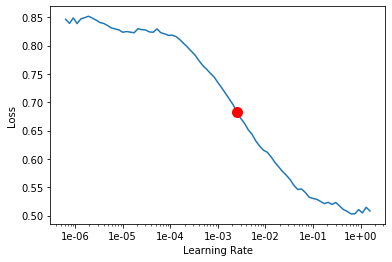

In [90]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [0]:
lr = 3e-2

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.287340,0.230417,0.907480,0,1,-398,1168,03:01


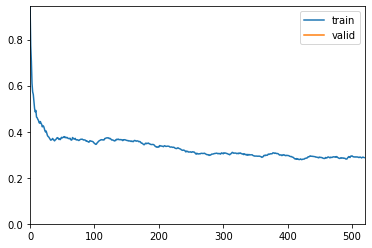

In [92]:
learn_clas.fit_one_cycle(1, max_lr=lr, moms=(0.8, 0.7))

In [0]:
learn_clas.save('26g-21')

In [0]:
learn_clas.load('26g-21');

## 6.4 ค่อย ๆ Unfreeze แล้วเทรน Layer Group ต่อ ๆ มา

เทรน Classifier โดยเทรน Layer Group สุดท้าย + Layer Group ก่อนหน้า

In [0]:
learn_clas.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 8.32E-07


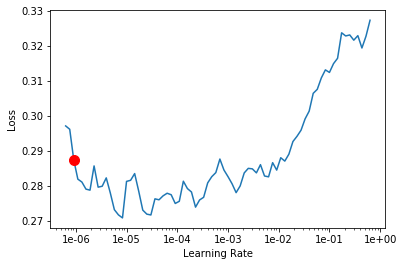

In [96]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [0]:
lr = 3e-4

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.258522,0.217318,0.914440,0,1,-424,1332,02:56


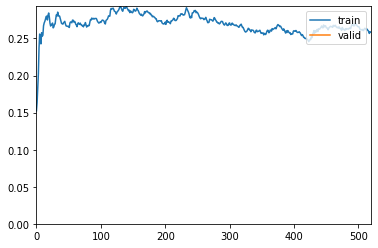

In [98]:
learn_clas.fit_one_cycle(1, max_lr=lr, moms=(0.8, 0.7))

In [0]:
learn_clas.save('26g-22')

In [0]:
learn_clas.load('26g-22');

## 6.5 ค่อย ๆ Unfreeze แล้วเทรน Layer Group ต่อ ๆ มา

เทรน Classifier โดยเทรน Layer Group สุดท้าย + Layer Group ก่อนหน้า + Layer Group ก่อนหน้าอีก

In [0]:
learn_clas.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 7.59E-08


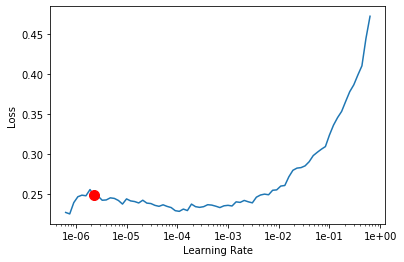

In [102]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [0]:
lr = 3e-5

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.256567,0.210449,0.918600,0,1,92,3398,04:00


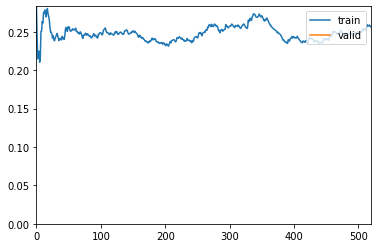

In [104]:
learn_clas.fit_one_cycle(1, max_lr=lr, moms=(0.8, 0.7))

In [0]:
learn_clas.save('26g-23')

In [0]:
learn_clas.load('26g-23');

## 6.6 Unfreeze แล้วเทรนทั้งโมเดล

Unfreeze ทั้งโมเดล แล้วเทรนต่อ

In [0]:
learn_clas.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 6.92E-05


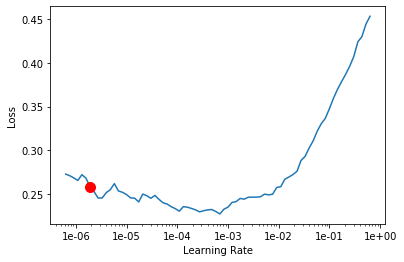

In [108]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [0]:
lr = 1e-4

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.225978,0.195751,0.924240,0,1,14,4898,05:12
1,0.193022,0.176560,0.929840,0,1,14,4770,05:49
2,0.166945,0.173017,0.935400,0,1,0,4870,05:21


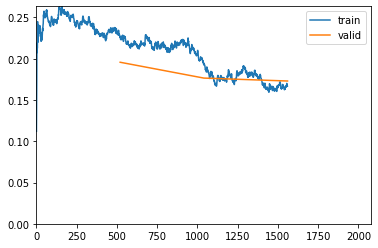

In [0]:
learn_clas.fit_one_cycle(4, max_lr=lr, moms=(0.8, 0.7))

โมเดลของเรา สามารถ Predict IMDB DataSet Sentiment Classification ได้ Accuracy ถึง 94% เทียบกับ 88% ใน [ep ที่แล้ว](https://www.bualabs.com/archives/3000/sentiment-classification-imdb-movie-reviews-with-naive-bayes-logistic-regression-nlp-ep-5/)

In [0]:
learn_clas.save('26g-24')

In [0]:
learn_clas.load('26g-24');

## 6.7 Predict

ลองให้โมเดล ทำนายข้อความ รีวิวหนัง Movie Review ที่เราเขียนเอง

รีวิวแง่บวก

In [0]:
learn_clas.predict('It is possibly one of the most completely wonderful story I have ever watched.')

In [0]:
learn_clas.predict('An intelligent, funny, charming, sweet film with surprising depth and heart.')

In [0]:
learn_clas.predict("I for one thought that this is an effective comedy movie that was really entertaining. I don't know what people's problem is that they have to dump on this movie so bad.")

รีวิวแง่ลบ

In [0]:
learn_clas.predict('Big disappointment even for non-discriminating zombie apocalypse movie fans.')

In [0]:
learn_clas.predict("Truly appalling This is an action thriller movie by numbers... but the action isn't very exciting and the plot holes just boring and annoy. ")

In [0]:
learn_clas.predict('A terrible "action" film remake that is more accidentally humorous than seriously suspenseful.')

# สรุป

* เราได้เรียนรู้วิธีการทำงาน และประโยชน์ของ Language Model และ vocab Dictionary 
* เราได้ใช้ Language Model ในการ Generate รีวิวหนัง Movie Review ที่อ่านแล้ว คล้ายกลับรีวิวหนังจริง ๆ
* เราใช้เทคนิค Transfer Learning ชื่อ ULMFit มาช่วยในการลดเวลา และเพิ่มประสิทธืภาพในการเทรน Deep Neural Network ใน [NLP](https://www.bualabs.com/archives/119/what-is-nlp-natural-language-processing-nlp-task-in-thai-nlp-ep-1/) เช่น Sentiment Analysis
* เราได้เรียนรู้การสร้าง Deep Neural Network ด้วยสถาปัตยกรรม AWD_LSTM ใช้ในงาน Sentiment Classification ที่มีประสิทธิภาพชนะ เทคนิคเก่า ๆ อย่างขาดลอย



# Credit

* https://www.youtube.com/watch?v=dt7sArnLo1g&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=6&t=0s
* https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/
* https://www.bualabs.com/archives/926/sentiment-analysis-imdb-movie-review-ulmfit-sentiment-analysis-ep-1/
* https://www.bualabs.com/archives/3000/sentiment-classification-imdb-movie-reviews-with-naive-bayes-logistic-regression-nlp-ep-5/
* https://docs.fast.ai/data_block.html
* https://docs.fast.ai/text.data.html
* https://forums.fast.ai/t/language-model-zoo-gorilla/14623
* https://www.imdb.com/interfaces/
* https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/
* https://arxiv.org/abs/1801.06146
* https://arxiv.org/abs/1708.02182
